<a href="https://colab.research.google.com/github/LivelyEKANSH/MachineLearning/blob/main/LoanApproval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'loan-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5216637%2F8698236%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240616%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240616T083920Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3e572693dba030dffa3a7d78b0407cb64a0450ca8e338a5a53826249806a76ae8a2b493688da71f9dd07f4db3b1dfa7c366fbc4469890bb676d94bb53b0b29af65453c663628f7884442e460b5ddf70acffb501e3e14592705799dc5fd34bd0ef14bd8cb686d53a4a5377e1e2b1e177997451db70e02aa76f27265d87279a3fcf34cda48c2c52e29533ad81b97a7bc36976e6d1066091addbc333e1ca601b1f83467e2bd82119ec98add5715742fe70a90c227b2d8912f0fdd7da5214130af8cef7022d1d6c61d872bec59bd8b399c3554bfda77c0015608ad151d96338655b4e8009ca70db791da7ac35b385418cfb474b10f12924d90462fd9336273a1f830'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np #
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-dataset/loan_approval_dataset.json


In [ ]:
filepath = '/kaggle/input/loan-dataset/loan_approval_dataset.json'
df = pd.read_json(filepath)
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [ ]:
df = df.drop(columns=['Id', 'CITY','STATE'],axis= 1)
df.rename(columns = {"Married/Single":"Married"}, inplace = True)
df = df.replace({'Married': {'married': 1, 'single': 0}})
df = df.replace({'Car_Ownership': {'yes': 1, 'no': 0}})
df.head()

/tmp/ipykernel_33/3343140116.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Married': {'married': 1, 'single': 0}})
/tmp/ipykernel_33/3343140116.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Car_Ownership': {'yes': 1, 'no': 0}})


,Income,Age,Experience,Married,House_Ownership,Car_Ownership,Profession,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,0,rented,0,Mechanical_engineer,3,13,0
1,7574516,40,10,0,rented,0,Software_Developer,9,13,0
2,3991815,66,4,1,rented,0,Technical_writer,4,10,0
3,6256451,41,2,0,rented,1,Software_Developer,2,12,1
4,5768871,47,11,0,rented,0,Civil_servant,3,14,1


In [ ]:
#data exploration
df.describe()

,Income,Age,Experience,Married,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,4.997117e+06,49.954071,10.084437,0.102095,0.301587,6.333877,11.997794,0.123000
std,2.878311e+06,17.063855,6.002590,0.302774,0.458948,3.647053,1.399037,0.328438
min,1.031000e+04,21.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,2.503015e+06,35.000000,5.000000,0.000000,0.000000,3.000000,11.000000,0.000000
50%,5.000694e+06,50.000000,10.000000,0.000000,0.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,0.000000,1.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,1.000000,1.000000,14.000000,14.000000,1.000000


In [ ]:
df.shape

(252000, 10)

In [ ]:
df.size

2520000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 0 to 251999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married            252000 non-null  int64 
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  int64 
 6   Profession         252000 non-null  object
 7   CURRENT_JOB_YRS    252000 non-null  int64 
 8   CURRENT_HOUSE_YRS  252000 non-null  int64 
 9   Risk_Flag          252000 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 21.1+ MB


In [ ]:
df.isnull().sum()

Income               0
Age                  0
Experience           0
Married              0
House_Ownership      0
Car_Ownership        0
Profession           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

Grouped by Marital Status:
Married
0    226272
1     25728
Name: count, dtype: int64
1=yes| 0=no


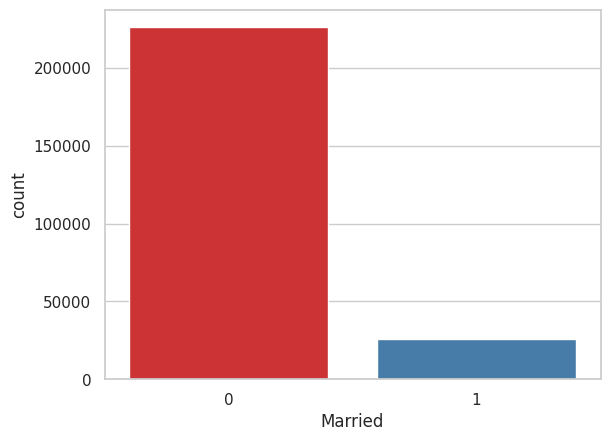

In [ ]:
#data visualization
print("Grouped by Marital Status:")
print(df['Married'].value_counts())
sns.countplot(x= 'Married', data= df, palette = 'Set1')
print("1=yes| 0=no")

Grouped by Car Ownership:
Car_Ownership
0    176000
1     76000
Name: count, dtype: int64
1=yes| 0=no


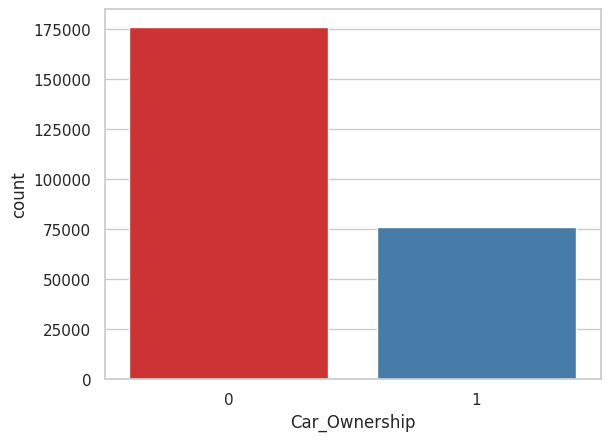

In [ ]:
print("Grouped by Car Ownership:")
print(df['Car_Ownership'].value_counts())
sns.countplot(x= 'Car_Ownership', data= df, palette = 'Set1')
print("1=yes| 0=no")

Grouped by House Ownership:
House_Ownership
rented          231898
owned            12918
norent_noown      7184
Name: count, dtype: int64


<Axes: xlabel='House_Ownership', ylabel='count'>

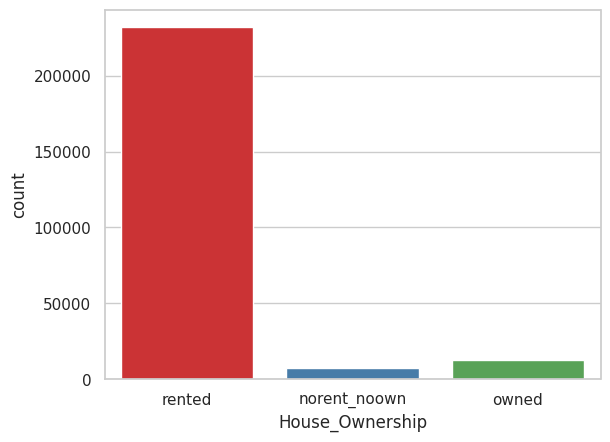

In [ ]:
print("Grouped by House Ownership:")
print(df['House_Ownership'].value_counts())
sns.countplot(x= 'House_Ownership', data= df, palette = 'Set1')

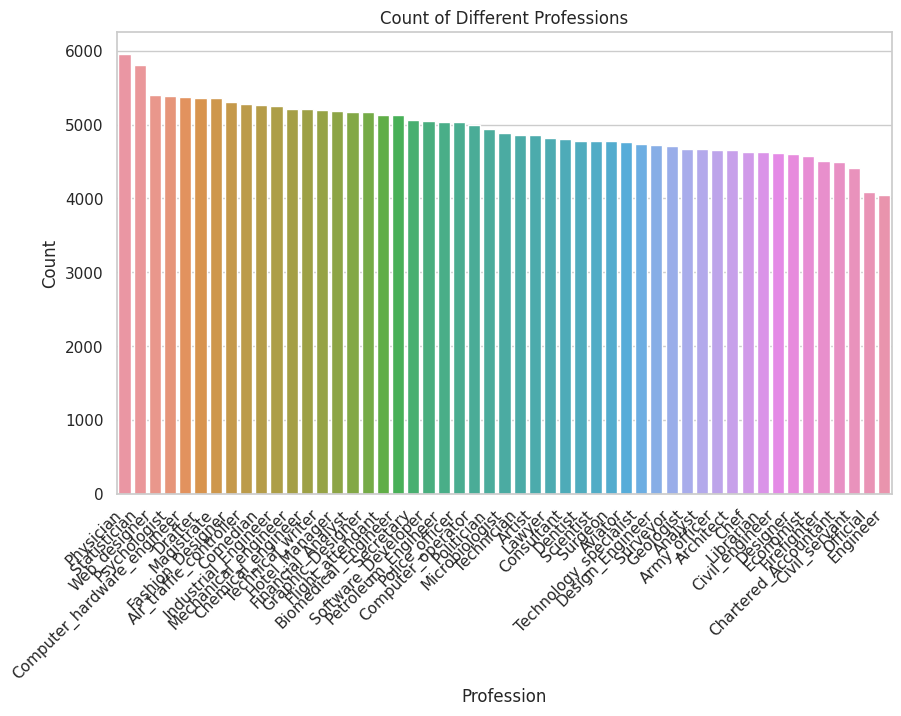

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Profession', data=df, order=df['Profession'].value_counts().index)
plt.xlabel('Profession')
plt.ylabel('Count')
plt.title('Count of Different Professions')
plt.xticks(rotation=45, ha='right')
plt.show()

Income Visualization


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

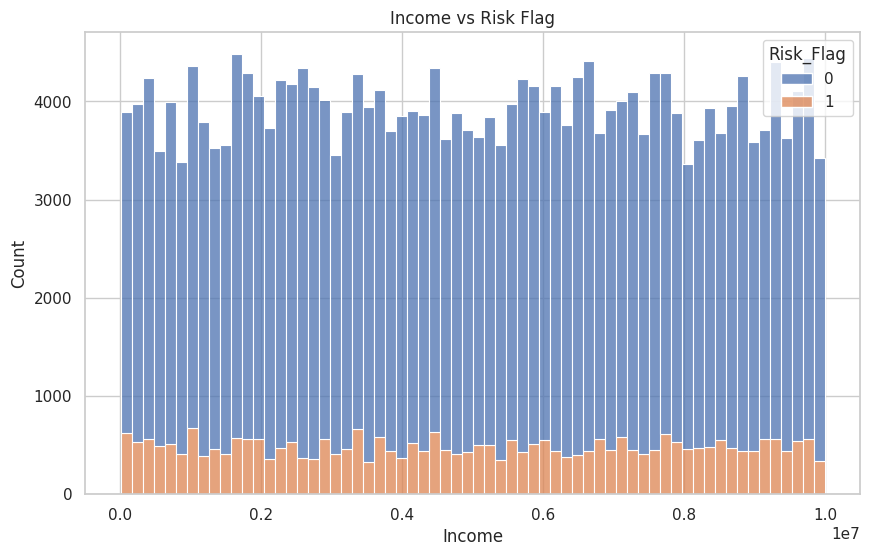

In [ ]:
print("Income Visualization")
plt.figure(figsize=(10, 6))
sns.histplot(df, x='Income', hue='Risk_Flag', multiple='stack')
plt.title('Income vs Risk Flag')
plt.show()

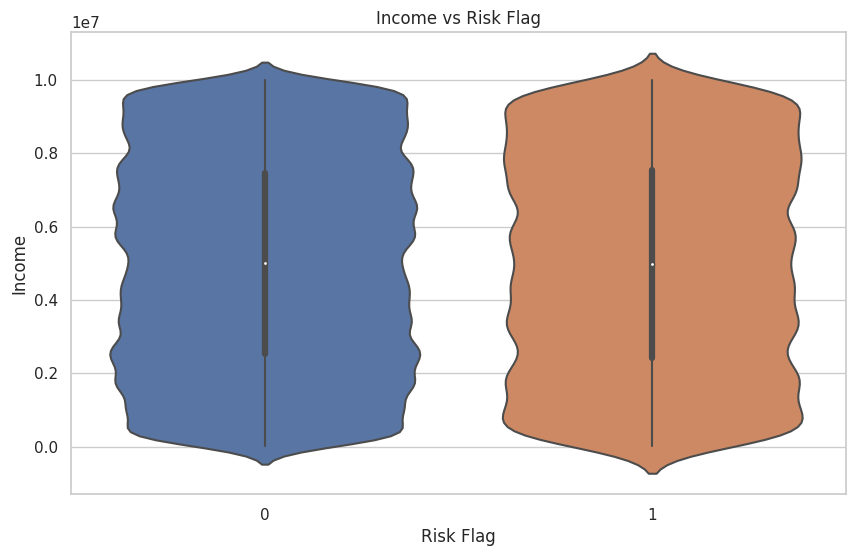

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Risk_Flag', y='Income', data=df)
plt.title('Income vs Risk Flag')
plt.xlabel('Risk Flag')
plt.ylabel('Income')
plt.show()

Age wise stats


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

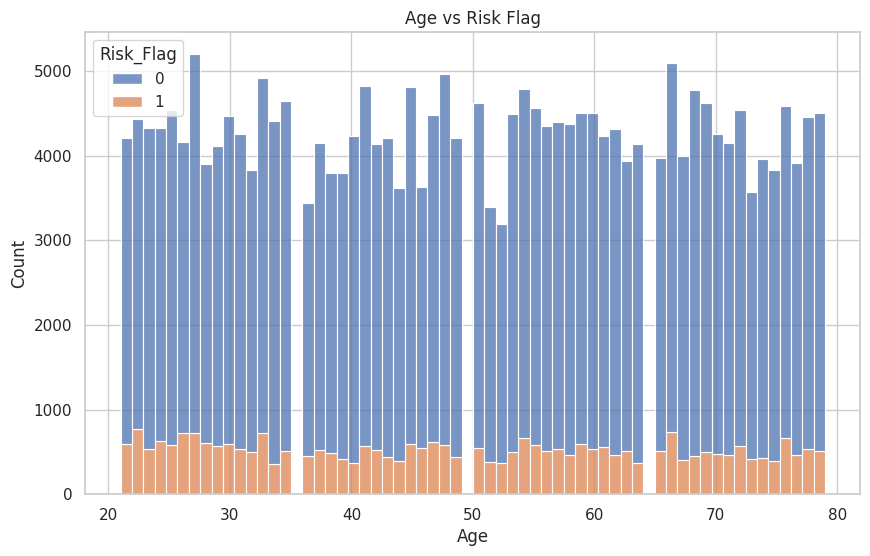

In [ ]:
print("Age wise stats")
plt.figure(figsize=(10, 6))
sns.histplot(df, x='Age', hue='Risk_Flag', multiple='stack')
plt.title('Age vs Risk Flag')
plt.show()

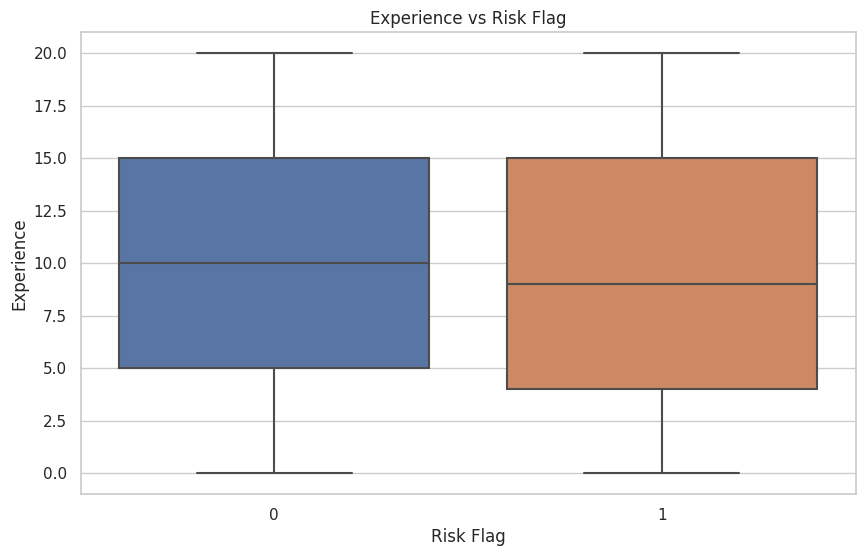

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Risk_Flag', y='Experience', data=df)
plt.title('Experience vs Risk Flag')
plt.xlabel('Risk Flag')
plt.ylabel('Experience')
plt.show()

In [ ]:
X = df.drop(columns=['Risk_Flag'])
y = df['Risk_Flag']

In [ ]:
df.isnull().sum()

Income               0
Age                  0
Experience           0
Married              0
House_Ownership      0
Car_Ownership        0
Profession           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [ ]:
numerical_value_columns = ['Income', 'Age', 'Experience', 'Married', 'Car_Ownership', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
categorical_value_columns = ['House_Ownership', 'Profession']

In [ ]:
numerical_values_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [ ]:
categorical_values_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_values', numerical_values_transformer, numerical_values),
        ('categorical_values', categorical_values_transformer, categorical_values)
    ])

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
print("Accuracy of the Model:", accuracy_score(y_test, y_pred))
print("Classification Report:\n\n", classification_report(y_test, y_pred))

Accuracy of the Model: 0.8989057239057239
Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.95      0.94     72999
           1       0.59      0.55      0.57     10161

    accuracy                           0.90     83160
   macro avg       0.77      0.75      0.76     83160
weighted avg       0.90      0.90      0.90     83160



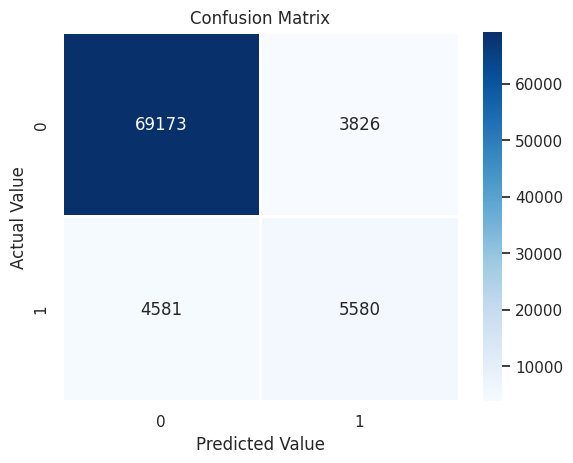

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths = 2)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix')
plt.show()

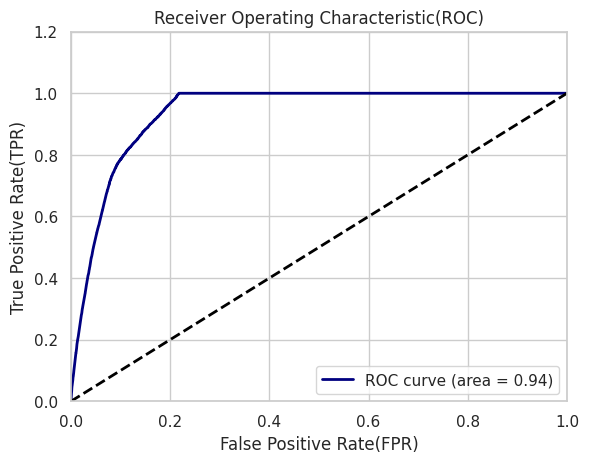

In [ ]:
y_pred_probability = clf.predict_proba(X_test)[:, 1]
fpr, tpr, x = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='Navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='Black', lw=2, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.2])
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic(ROC)')
plt.legend(loc="lower right")
plt.show()

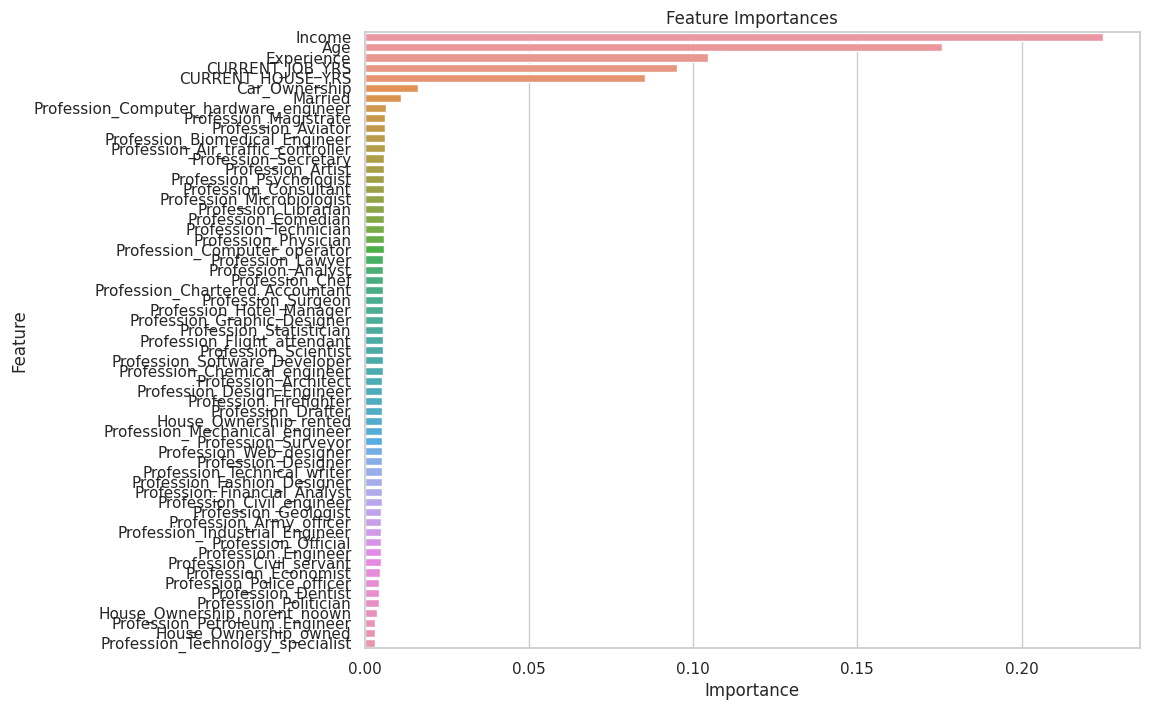

In [ ]:
feature_importances = clf.named_steps['model'].feature_importances_


categorical_features = clf.named_steps['preprocessor'].named_transformers_['categorical_values']['onehot'].get_feature_names_out(categorical_value_columns)
feature_names = numerical_value_columns + list(categorical_features)


importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})



importances_df = importances_df.sort_values(by='Importance', ascending=False)



plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.show()

In [ ]:
print("Therefore Income, Age, Experience, Current_Job_Yrs, Current_House_Yrs are of maximum importance since they have the highest information gain")

Therefore Income, Age, Experience, Current_Job_Yrs, Current_House_Yrs are of maximum importance since they have the highest information gain
